# Задание 1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

### Открытие сsv файлов

In [2]:
reg_df = pd.read_csv('problem1-reg_data.csv', sep=';')
auth_df = pd.read_csv('problem1-auth_data.csv', sep=';')

### Проверка содержимого датафреймов и типов данных в их колонках

In [3]:
reg_df.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
reg_df.dtypes

reg_ts    int64
uid       int64
dtype: object

In [5]:
auth_df.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [6]:
auth_df.dtypes

auth_ts    int64
uid        int64
dtype: object

Так как данные в обоих таблицах числовые, для оптимизации вычислений приводим колонки 'auth_ts' и 'reg_ts' к типу **datetime**, а колонки 'uid' к типу **str**, для избежания пропуска уникальных значений:

In [7]:
reg_df['reg_ts'] = pd.to_datetime(reg_df['reg_ts'], unit='s')
auth_df['auth_ts'] = pd.to_datetime(auth_df['auth_ts'], unit='s')
reg_df['uid'] = reg_df['uid'].astype('str')
auth_df['uid'] = auth_df['uid'].astype('str')

### Измерение процентного соотношения распределения количества регистраций от общего количества записей в датафрейме

In [8]:
round(reg_df.reg_ts.dt.year.value_counts(normalize=True),3)

2020    0.355
2019    0.291
2018    0.160
2017    0.088
2016    0.048
2015    0.026
2014    0.014
2013    0.008
2012    0.004
2011    0.002
2010    0.001
2009    0.001
2008    0.000
2007    0.000
2006    0.000
2005    0.000
2004    0.000
2003    0.000
2002    0.000
2001    0.000
2000    0.000
1999    0.000
1998    0.000
Name: reg_ts, dtype: float64

Из полученной таблицы видно, что мобильная игра до **2015 года** находилась на ранней стадии развития. Ежегодное количество пользователей превысило значение в **2.6%** от общего их числа только в **2015** году. Примем за начало отсчета статистики 2015 год. Для качественной оценки **Retention rate** до **2015 года** недостаточно данных.

Оставим значения с 2015 года включительно:

In [9]:
reg_df_2015 = reg_df.query('reg_ts.dt.year >= 2015')

In [10]:
auth_df_2015 = auth_df.query('auth_ts.dt.year >= 2015')

In [11]:
reg_df_2015.shape[0]

967970

In [12]:
reg_df.shape[0]

1000000

In [13]:
reg_df.shape[0] - reg_df_2015.shape[0]

32030

In [14]:
round((reg_df.shape[0] - reg_df_2015.shape[0])/reg_df.shape[0]*100, 2)

3.2

Отсеивание логированных данных о регистрации до 2015 года сократило датафрейм reg_df на **32030 записей**, что составляет **3,2%** от общего количества записей.

In [15]:
auth_df_2015.shape[0]

9309313

In [16]:
auth_df.shape[0]

9601013

In [17]:
auth_df.shape[0] - auth_df_2015.shape[0]

291700

In [18]:
round((auth_df.shape[0] - auth_df_2015.shape[0])/auth_df.shape[0]*100, 2) 

3.04

Отсеивание логированных данных об авторизации до 2015 года сократило датафрейм auth_df на **291700** записей, что составлет **3,04%** от общего количества записей.

### Для рассчета Retention rate по дням необходимо получить данные о количестве дней между каждым посещением и датой регистрации

Создадим датафрейм **timedelta_df**, в котором отсортируем данные по уникальному пользователю и каждому его посещению:

In [19]:
timedelta_df = auth_df_2015\
.reset_index()\
.groupby(['index','uid','auth_ts'], as_index = False)\
.agg({'index': 'count'})\
.drop(columns = 'index')\
.sort_values(['uid', 'auth_ts'])

Создадим в этом датафрейме колонку **delta**, в которой посчитаем данные о временной разнице между последовательными посещениями:

In [20]:
timedelta_df['delta'] = timedelta_df['auth_ts'].diff(periods = 1)

In [21]:
timedelta_df

,uid,auth_ts,delta
554050,100000,2016-09-20 02:33:46,NaT
8348970,1000000,2020-07-21 19:58:14,1400 days 17:24:28
8348979,1000001,2020-07-21 19:59:12,0 days 00:00:58
8416339,1000001,2020-07-26 12:14:31,4 days 16:15:19
8456773,1000001,2020-07-29 07:45:01,2 days 19:30:30
...,...,...,...
8960481,999999,2020-09-01 04:42:45,3 days 12:16:06
9015120,999999,2020-09-04 18:14:23,3 days 13:31:38
9094857,999999,2020-09-09 22:14:16,5 days 03:59:53
9191944,999999,2020-09-16 03:59:54,6 days 05:45:38


Проверим, есть ли значения, характерные для перехода с предыдущего пользователя на следующего, а именно, отрицательные значения между заранее сгруппированными посещениями, что должно отразиться в колонке **delta**. 
Предлагаю принять за характерное для такой активности время сессии < 0 минут:

In [22]:
timedelta_df.query('delta < "0 days 00:00:00"').shape[0]

272323

Проверим, есть ли значения, характерные для подозрительной активности, а именно, частые перезаходы в игру, что должно отразиться в колонке **delta**.
Предлагаю принять за характерное для такой активности время сессии от 0 до 5 минут:



In [23]:
timedelta_df.query('"0 days 00:00:00" <= delta <= "0 days 00:05:00"').shape[0]

576064

Фильтруем паразитные значения, отсеивая потенциальных ботов и наши служебные значения:

In [24]:
cleared_timedelta_df = timedelta_df.query('delta > "0 days 00:05:00"')

Посмотрим, сколько подозрительных пользователей мы убрали из нашей выборки:

In [25]:
auth_df_2015.shape[0] - cleared_timedelta_df.shape[0]

848388

In [26]:
round((auth_df_2015.shape[0] - cleared_timedelta_df.shape[0])*100/auth_df_2015.shape[0],2)

9.11

Путем преобразований данных **с 2015 года** было убрано **848388** строк, что составляет **9.11%** паразитных данных от выборки. 

### Соединение датафрейма с данными о регистрации  reg_df_2015 с датафреймом фильтрованных данных об аутентификации cleared_timedelta_df

In [27]:
retention_df = cleared_timedelta_df.merge(reg_df_2015,how='left', on='uid').rename(columns={'uid': 'UserID', 'auth_ts': 'Auth', 'reg_ts': 'Registration', 'delta': 'Delta'})

Проверим правильность выполненного соединения датафреймов:

In [28]:
cleared_timedelta_df.shape[0]

8460925

In [29]:
retention_df.shape[0]

8460925

Количество строк **retention_df** совпадает с количеством строк **cleared_timedelta_df**, значит конкатенация прошла успешно.

Проверяем на наличие отсутствующих значений:

In [30]:
retention_df.isna().sum()

UserID               0
Auth                 0
Delta                0
Registration    837453
dtype: int64

Для **1025572** строк отсутствует значение даты регистрации. Построить для данных пользователей **Retention rate** невозможно. 
Уберем их:

In [31]:
retention_df.dropna(subset=['Registration'], inplace=True)

Проверяем на наличие отсутствующих значений еще раз:

In [32]:
retention_df.isna().sum()

UserID          0
Auth            0
Delta           0
Registration    0
dtype: int64

Удаление строк выполнено успешно.

### Определение функции для расчета Retention rate

In [33]:
def retention_rate(retention_df, retention_depth, min_date, max_date):  
    
    
    #Создаем колонки reg и auth для того чтобы считать количество дней с момента регистрации не по количеству часов в сутках, а по дню:
    
    cohort = retention_df
    cohort['reg']=retention_df.Registration.dt.date
    cohort['auth']=retention_df.Auth.dt.date    

    
    #Находим количество дней с момента регистрации до каждой даты входа в игру и добавляем полученные значения в итоговый датафрейм:
    
    cohort['days'] = (cohort['auth']-cohort['reg']).apply(lambda x: x.days)    
    
    
    ''' 
    Отсеиваем значения данных неподходящие под переданные нами в аргументы функции, после чего группируем датафрейм по дате регистрации и количеству дней с регистрации,
    находим количество уникальных пользователей для каждой даты:
    '''

    cohort = cohort.loc[(cohort['Registration'] >= min_date) & (cohort['Auth'] <= max_date) & (cohort['days'] <= retention_depth)].groupby(['reg','days'], as_index= False).agg({'UserID':'nunique'})
   

    '''
    Делаем сводную таблиц. Индексами в ней выступают значения дат регистрации, колонками количество дней с момента регистрации,
    а значениями количсетво уникальных пользователей в каждый из дней:
    '''
    
    retention_table = cohort.pivot_table (index='reg', columns='days', values='UserID')
    
    
    #Указываем когорту с которой будем сравнивать значения количества заходов в игру в последующие дни:
    
    cohort_size = retention_table.iloc[:,0]
    
    
    #Рассчитываем retention_rate для каждого дня:
    
    retention_rate = retention_table.divide(cohort_size, axis=0).round(3)
    

    #Визуализируем полученную таблицу через heatmap для наглядного отображения закономерностей:
    
    plt.figure(figsize=(20,15))
    plt.title('Retention rate for Gamers')
    sns.heatmap(data=retention_rate,
           vmin=0.0,
           vmax=0.8,
           cmap='YlGnBu',
           annot=True,
           fmt='.00%')
    plt.show()

Указываем аргументы в функции, а именно: **DF**, глубину расчета **Retention rate**, **дату регистрации первой когорты**, **дату регистрации последней когорты**:

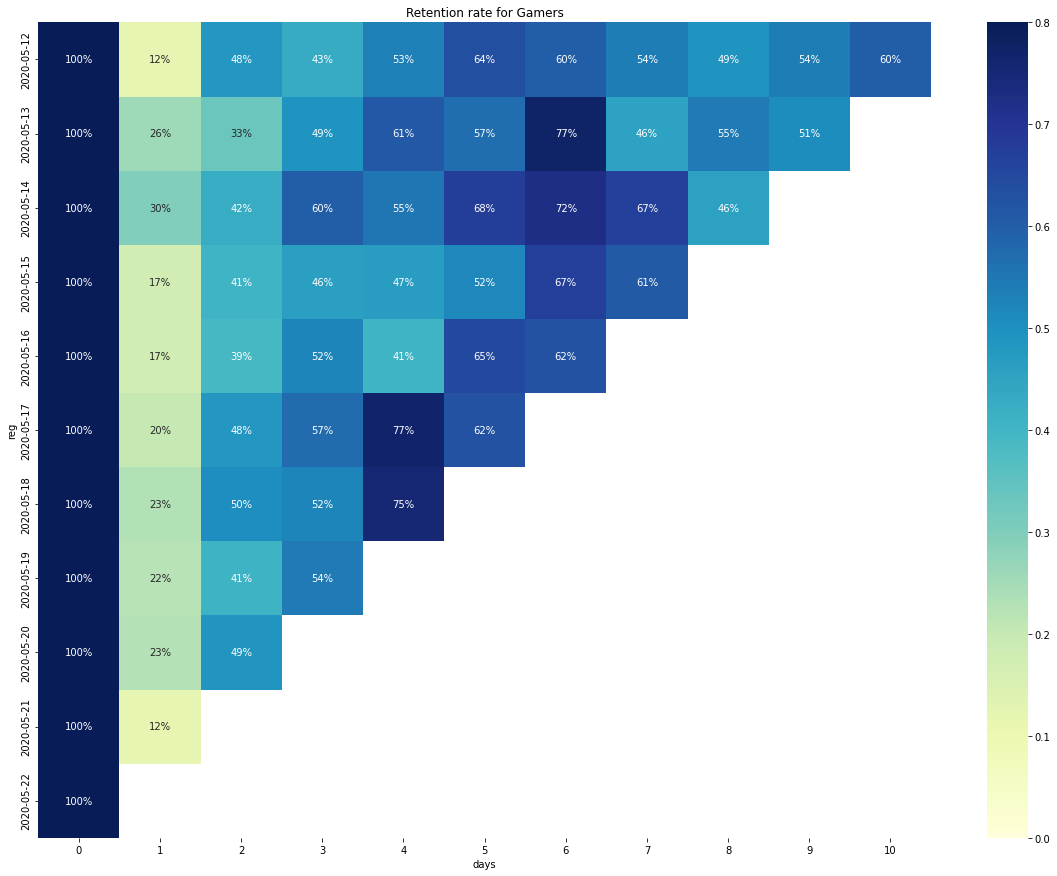

In [34]:
retention_rate(retention_df, 12, '2020-05-12', '2020-05-23')